# Analyzing Chilean Mutual Funds

## Imports

Most of the code required to run our analysis is located within th `dva` package, so we only need to import that and a few others.

In [55]:
import pathlib

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.cluster import KMeans

import dva

In [2]:
HERE = pathlib.Path('.').cwd()
DATA_DIR = HERE.joinpath('data')
RAW_FILES = DATA_DIR.joinpath('raw')


## Pull Data from Web

Here we connect to the AAFM Public Daily Statistics API to pull daily mutual fund data from 2015 through our project start (Feb 13, 2021).  Each JSON response is converted to a Pandas DataFrame and exported to CSV in the `RAW_FILES` directory. 

In [ ]:
dates = dva.get_dates('2015-01-01', '2021-02-13')
dva.pull_all(dates, RAW_FILES)

## Convert Raw Data to Parquet

We use Dask to extract and subset raw data into separate, compressed parquet files:

- `fund_data.parq`, containing static, descriptive and categorical data on each unique mutual fund;
- `fund_flows.parq`, containing time series data on mutual fund inflows and outflows, 2015 - 2021;
- `fund_prices.parq`, containing time series data on mutual fund prices, 2015 - 2021.

In [ ]:
dva.raw_to_parq(RAW_FILES, DATA_DIR)

## Transform and Join Data

We join our static fund data with time series fund data, downsample to monthly price observations, and tranform monthly prices into monthly percentage returns.

We filter out observations that have **at least** 36 months of data and still exist in the most recent month.  We'll also filter out any observations whose price does not change across the entire time period.


In [41]:
price_data = DATA_DIR.joinpath('fund_prices.parq')
fund_data = DATA_DIR.joinpath('fund_data.parq')

prices = dva.get_monthly_prices(price_data)
fund_data_monthly_prices = dva.clean_from_monthly_prices_raw(dva.remove_closed_funds(dva.join_fund_data(prices, fund_data)))
fund_data_monthly_prices.drop(['svsCategoryId', 'currency'], axis=1, inplace=True)

In [42]:
static = dva.get_static_data(fund_data_monthly_prices)
prices = dva.get_price_data(fund_data_monthly_prices)
returns = dva.get_return_data(prices)
dataset = dva.make_dataset(static, returns)
cat_means = dva.get_category_means(dataset)
monthly_returns = dva.fill_na(dataset, cat_means)

## Map Fund Return Data to Lower Dimensions, Join with Fund Flows Data



In [43]:
mapped = dva.map_all_by_group(monthly_returns.fillna(0), 'tsne')
fund_flows = dva.get_fund_flows_2020(DATA_DIR.joinpath('fund_flows.parq'))
fund_data_monthly_returns_tsne = mapped.merge(fund_flows, on='fundRUNSeries')

sc = MinMaxScaler((10, 50))
fund_data_monthly_returns_tsne['netPatrimony_scaled'] = sc.fit_transform(fund_data_monthly_returns_tsne['netPatrimony'].values.reshape(-1, 1))

/Users/christophersantiago/Dropbox/School/GIT_Work/CSE_6242/aafm/_final_report/dva/clean.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  assets['fundRUNSeries'] = assets['fundRUN'] + assets['fundSeries']


## Calculate Annualized Fund Metrics, Join



In [44]:
fund_stats = dva.add_perf_metrics(fund_data_monthly_prices)
data = fund_data_monthly_returns_tsne.merge(fund_stats[['fundRUNSeries', 'ann_return', 'ann_stdev']], on='fundRUNSeries')
data['ann_return'] = data['ann_return'] * 100
data['ann_stdev'] = data['ann_stdev'] * 100

/Users/christophersantiago/Dropbox/School/GIT_Work/CSE_6242/aafm/_final_report/dva/fund_performance.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fund_data['ann_return'] = ts.apply(lambda x: get_cagr(x), axis=1)
/Users/christophersantiago/Dropbox/School/GIT_Work/CSE_6242/aafm/_final_report/dva/fund_performance.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fund_data['ann_stdev'] = ts.apply(lambda x: get_ann_std(x), axis=1)


## Find Anomalies



In [45]:
all_data = []
for aafm_cat in data['aafmCategory'].unique():
    mask = data['aafmCategory'] == aafm_cat
    df = data[mask].copy()
    df['dist_anomaly'] = dva.get_anomalies(df, 1.75)
    all_data.append(df)
scored = pd.concat(all_data).sort_index()

## Clustering with K-Means

Here we'll cluster our funds for the purpose of re-creating a covariance and/or correlation matrix.  We'll start with 31 unique fund categories, and re-group into 10 unique clusters.

## Selecting subset of columns

We'll use the annualized returns and standard deviation, along with the TSNE components, to cluster the funds.  We're not including the monthly returns as that information is already encoded in the TSNE components.

In [50]:
cols = data.columns[-4:-2] # only use annual return and stdev
cols = cols.append(data.columns[-9:-7])  # adds tSNE coordinates
df = data[cols]

## Run K-means pipeline and plot results

We'll use our original TSNE mapping, but replace the `aafmCategory` factor with our new cluster labels.

### Choosing Number of Clusters

We examined results of four methods to determine appropriate number of clusters:
- Elbow method
- Calinski-Harabasz
- Silhouette
- Davies-Bouldin

The elbow method is rather subjective.  Results indicate the optimal number could lie between 7-10 clusters.

The Calinski-Harabasz score is inconclusive-- the score exhibits multiple, increasing peaks.  The Silhouette and Davies-Bouldin scores indicate that 10 clusters may be appropriate; therefore, we choose to use 10 clusters.

In [58]:
pl = Pipeline(
        steps=[
            ('scaler', StandardScaler()),
            ('cluster', KMeans(n_clusters=10, n_init=20, random_state=7))
        ]
    )
pl.fit(df)
labels = pl.named_steps['cluster'].labels_
n_clusters = len(np.unique(labels))
scored['cluster'] = labels

In [60]:
file_name = 'FundDataWithMonthlyReturnsTSNEScoredScaledClustered.csv'
scored.to_csv(DATA_DIR.joinpath(file_name))

## Efficient Frontier Portfolio

We'll now use generate portfolios of mutual fund assets to create efficient frontiers per Modern Portfolio Theory.  We'll first use our K-Means generated clusters and then the original AAFM categores.

In [61]:
data_cluster=scored.loc[:,'2015-01-31':'2021-01-31']
data_cluster['cluster']=scored['cluster']
data_cluster=data_cluster.groupby('cluster').mean().T
data_cluster=data_cluster[1:]
data_cluster.head()

cluster,0,1,2,3,4,5,6,7,8,9
2015-02-28,0.005185,0.004418,0.021884,0.002235,0.017436,0.010739,0.002285,0.017642,0.001153,0.026520
2015-03-31,0.001373,0.002997,-0.010492,0.002055,-0.002999,0.001621,0.002114,-0.017665,0.003305,0.001321
2015-04-30,0.000488,-0.000770,0.028082,0.001666,0.015343,0.003875,0.001724,0.019487,-0.002639,0.001762
2015-05-31,0.001779,0.002930,-0.010276,0.001876,-0.005186,0.001738,0.001936,-0.014352,0.002468,0.006002
2015-06-30,-0.005953,0.003253,-0.025093,0.001797,-0.011186,-0.005999,0.001829,-0.002306,0.004966,-0.009438


In [63]:
cluster_funds=data['userCategory'].unique()

#create 6000 portfolios so we can have a sample of almost all portfolio condition due to volatility and returns.
np.random.seed(42)
num_ports = 6000
all_weights = np.zeros((num_ports, len(data_cluster.columns)))
ret_arr = np.zeros(num_ports)
vol_arr = np.zeros(num_ports)
sharpe_arr = np.zeros(num_ports)

for x in range(num_ports):
    # Weights
    weights = np.array(np.random.random(10))
    weights = weights/np.sum(weights)
    
    # Save weights
    all_weights[x,:] = weights
    
    # Expected return
    ret_arr[x] = np.sum( (data_cluster.mean() * weights * 12))
    
    # Expected volatility
    vol_arr[x] = np.sqrt(np.dot(weights.T, np.dot(data_cluster.cov()*12, weights)))
    
    # Sharpe Ratio
    sharpe_arr[x] = ret_arr[x]/vol_arr[x]

In [64]:
#the optimal portfolio is located in this point.
print('Max sharpe ratio in the array: {}'.format(sharpe_arr.max()))
print('Location in the array: {}'.format(sharpe_arr.argmax()))

Max sharpe ratio in the array: 0.7595716197811605
Location in the array: 1901


In [66]:
#the weight of the optimal portfolio is:
print(all_weights[1901,:]*100)

[25.07334659 23.94227984 12.54861539  2.57000829  0.40159012  9.56528158
  0.30613054  7.63719011 13.92519844  4.0303591 ]


In [67]:
max_sr_ret=ret_arr[sharpe_arr.argmax()]
max_sr_vol=vol_arr[sharpe_arr.argmax()]

### Sample Portfolios Using K-Mean Clusters

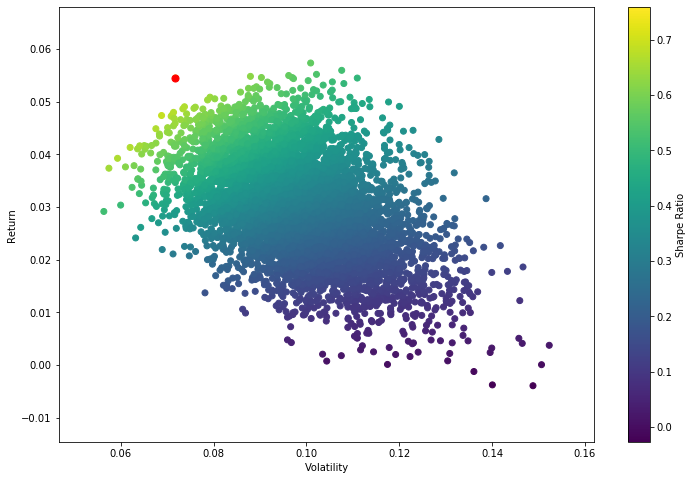

In [68]:
plt.figure(figsize=(12,8))
plt.scatter(vol_arr, ret_arr, c=sharpe_arr, cmap='viridis')
plt.colorbar(label='Sharpe Ratio')
plt.xlabel('Volatility')
plt.ylabel('Return')
plt.scatter(max_sr_vol, max_sr_ret,c='red', s=50) # red dot
pclt.show()

In [100]:
#pd.DataFrame(vol_arr,ret_arr)
efficient_frontier_cluster=pd.DataFrame(all_weights*100,columns=cluster_funds)
efficient_frontier_cluster['x_coord_vol']=vol_arr
efficient_frontier_cluster['y_coord_ret']=ret_arr
efficient_frontier_cluster.head()

,"Domestic Bond, < 365",Domestic Equity,International Equity,"Balanced, Aggressive","Balanced, Moderate","Balanced, Conservative","Domestic Bond, > 365",Emerging Equity,"International Bond, > 365","International Bond, < 365",x_coord_vol,y_coord_ret
0,7.200801,18.278161,14.073106,11.509637,2.999570,2.999106,1.116699,16.652855,11.556865,13.613201,0.089412,0.044501
1,0.520773,24.538041,21.060217,5.372031,4.600045,4.640006,7.697116,13.275971,10.927907,7.367894,0.098845,0.047058
2,15.281528,3.483974,7.296552,9.150188,11.390722,19.610414,4.987017,12.843427,14.796040,1.160137,0.079321,0.024918
3,11.929704,3.348399,1.277348,18.632243,18.961076,15.873628,5.981372,1.917882,13.435547,8.642800,0.110369,0.011932
4,3.016589,12.239978,0.850029,22.476941,6.396626,16.376487,7.704997,12.855247,13.513800,4.569305,0.096981,0.031127


In [101]:
file_name = 'efficient_frontier_kmeans_cluster_withweights.csv'
efficient_frontier_cluster.to_csv(DATA_DIR.joinpath(file_name))

We continue with the aafm categories.

In [41]:
data_aafm=data.loc[:,'2015-01-31':'2021-01-31']
data_aafm['aafmCategory']=data['aafmCategory']
data_aafm=data_aafm.groupby('aafmCategory').mean().T
data_aafm=data_aafm[1:]
data_aafm.head()

aafmCategory,Accionario America Latina,Accionario Asia Emergente,Accionario Asia Pacifico,Accionario Brasil,Accionario Desarrollado,Accionario EEUU,Accionario Emergente,Accionario Europa Desarrollado,Accionario Europa Emergente,Accionario Nacional Large CAP,...,Fondos de Deuda < 90 Dias Nacional,"Fondos de Deuda > 365 Dias Internacional, Mercados Emergentes","Fondos de Deuda > 365 Dias Internacional, Mercados Internacionales","Fondos de Deuda > 365 Dias Nacional, Inversion UF > 3 años y =<5","Fondos de Deuda > 365 Dias Nacional, Inversion en UF > 5 años","Fondos de Deuda > 365 Dias Nacional, Inversión en Pesos","Fondos de Deuda > 365 Dias Nacional, Inversión en UF < 3 años",Fondos de Deuda > 365 Dias Orig. Flex,Inversionistas Calificados Accionario Nacional,Inversionistas Calificados Títulos de Deuda
2015-02-28,0.018239,-0.007164,0.026657,0.005819,0.028310,0.034027,0.002256,0.037605,0.039818,0.035919,...,0.002411,0.006992,-0.007591,0.009520,0.008691,0.001830,0.007933,0.005793,0.043719,0.0
2015-03-31,-0.052730,0.011905,0.009811,-0.089508,0.001521,-0.002829,-0.003580,0.013985,-0.023105,-0.015522,...,0.002269,-0.002451,0.003811,0.006403,0.007382,0.000668,0.005933,0.004325,-0.011888,0.0
2015-04-30,0.051737,0.029131,0.002823,0.073876,-0.005492,-0.016480,0.035318,-0.012843,0.081792,0.022690,...,0.001872,0.019257,-0.012289,-0.006371,-0.008377,0.001641,-0.003525,-0.002823,0.019223,0.0
2015-05-31,-0.042291,-0.009808,0.007896,-0.075085,0.012067,0.017419,-0.020220,0.017595,-0.029704,-0.008358,...,0.001764,0.002855,0.000312,0.004804,0.004340,0.001824,0.005050,0.004128,-0.010798,0.0
2015-06-30,0.017162,-0.006494,0.002663,0.058787,-0.000116,0.006180,-0.007906,-0.011900,-0.017682,-0.038001,...,0.000498,-0.011466,0.006912,0.005437,0.004612,0.004684,0.005896,0.004870,-0.041493,0.0


In [112]:
aafm_funds=data_aafm.columns

In [103]:
#create 6000 portfolios so we can have a sample of almost all portfolio condition due to volatility and returns.
np.random.seed(42)
num_ports = 6000
all_weights = np.zeros((num_ports, len(data_aafm.columns)))
ret_arr = np.zeros(num_ports)
vol_arr = np.zeros(num_ports)
sharpe_arr = np.zeros(num_ports)

for x in range(num_ports):
    # Weights
    weights = np.array(np.random.random(31))
    weights = weights/np.sum(weights)
    
    # Save weights
    all_weights[x,:] = weights
    
    # Expected return
    ret_arr[x] = np.sum( (data_aafm.mean() * weights * 12))
    
    # Expected volatility
    vol_arr[x] = np.sqrt(np.dot(weights.T, np.dot(data_aafm.cov()*12, weights)))
    
    # Sharpe Ratio
    sharpe_arr[x] = ret_arr[x]/vol_arr[x]

In [104]:
#the optimal portfolio is located in this point.
print('Max sharpe ratio in the array: {}'.format(sharpe_arr.max()))
print('Location in the array: {}'.format(sharpe_arr.argmax()))

Max sharpe ratio in the array: 0.6814865771958846
Location in the array: 2738


In [105]:
#the weight of the optimal portfolio is:
print(all_weights[2738,:]*100)

[2.16434254 3.80924549 0.9618146  1.13745997 2.62600107 3.61789488
 5.18160031 3.3737793  0.18014507 2.00168607 0.18301067 6.78121815
 0.21449431 0.36634492 2.20348541 4.67127651 2.64437635 0.45481278
 6.17773619 5.17282072 2.92816549 5.00059403 2.02848805 3.89957947
 6.50468197 0.79548493 6.2563563  5.82533542 7.01140375 3.79548334
 2.03088193]


In [106]:
max_sr_ret=ret_arr[sharpe_arr.argmax()]
max_sr_vol=vol_arr[sharpe_arr.argmax()]

### Sample Portfolios Using Original AAFM Categories

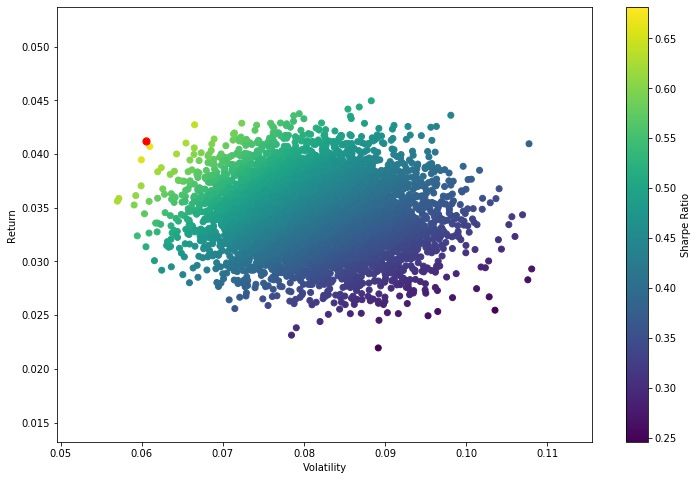

In [107]:
plt.figure(figsize=(12,8))
plt.scatter(vol_arr, ret_arr, c=sharpe_arr, cmap='viridis')
plt.colorbar(label='Sharpe Ratio')
plt.xlabel('Volatility')
plt.ylabel('Return')
plt.scatter(max_sr_vol, max_sr_ret,c='red', s=50) # red dot
plt.show()

In [114]:
efficient_frontier_aafm=pd.DataFrame(all_weights*100,columns=aafm_funds)
efficient_frontier_aafm['x_coord_vol']=vol_arr
efficient_frontier_aafm['y_coord_ret']=ret_arr
efficient_frontier_aafm.head()

aafmCategory,Accionario America Latina,Accionario Asia Emergente,Accionario Asia Pacifico,Accionario Brasil,Accionario Desarrollado,Accionario EEUU,Accionario Emergente,Accionario Europa Desarrollado,Accionario Europa Emergente,Accionario Nacional Large CAP,...,"Fondos de Deuda > 365 Dias Internacional, Mercados Internacionales","Fondos de Deuda > 365 Dias Nacional, Inversion UF > 3 años y =<5","Fondos de Deuda > 365 Dias Nacional, Inversion en UF > 5 años","Fondos de Deuda > 365 Dias Nacional, Inversión en Pesos","Fondos de Deuda > 365 Dias Nacional, Inversión en UF < 3 años",Fondos de Deuda > 365 Dias Orig. Flex,Inversionistas Calificados Accionario Nacional,Inversionistas Calificados Títulos de Deuda,x_coord_vol,y_coord_ret
0,2.720868,6.906519,5.317612,4.348989,1.133406,1.133231,0.421952,6.292387,4.366835,5.143834,...,2.661457,3.313147,5.703956,1.450542,3.735686,4.303630,0.337442,4.413545,0.088201,0.034593
1,1.141041,0.435285,6.349350,6.461407,5.409291,2.038285,0.653561,4.578460,2.945226,0.816604,...,4.000774,6.168607,0.592137,1.311395,0.302633,2.176908,2.600786,1.815698,0.086637,0.029327
2,5.381979,2.316824,1.824442,3.524372,0.915189,5.209620,0.484146,6.409032,5.015105,1.290498,...,2.111803,4.738202,4.140420,5.761729,3.066654,0.776668,4.631948,4.940683,0.085535,0.036903
3,3.674159,5.046803,3.232419,3.421844,2.798712,0.166395,0.706265,0.205738,4.165986,2.057796,...,5.260892,1.221300,5.842752,3.530571,5.285558,5.865874,2.081672,0.720407,0.075010,0.034249
4,1.592160,2.983409,5.713950,6.012326,0.048562,3.567643,2.915676,1.551455,0.837277,2.358290,...,3.511285,0.359586,1.946385,6.344367,1.673374,1.012111,3.418898,6.884909,0.090297,0.030318


In [115]:
file_name = 'efficient_frontier_kmeans_aafmcat_withweights.csv'
efficient_frontier_cluster.to_csv(DATA_DIR.joinpath(file_name))